In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
tqdm.pandas()
import seaborn as sns
import functools
import operator
import os
import swifter
import collections
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import StandardScaler, LabelEncoder
from nltk.tokenize import word_tokenize
# pd.set_option('display.max_colwidth', -1)
file = "cleaned_data.csv"
SEED=32


In [2]:
nlp = ['Package Name', 'Destination', 'Itinerary', 'Places Covered', 'Hotel Details', 'Airline',
       'Sightseeing Places Covered']
cat_cols = ['Package Type', 'Start City', 'Cancellation Rules']
reg_cols = ['Flight Stops', 'Meals', 'destination_count',
       'airlines_count', 'sightseeing_count', 'hotel_details_count',
       'place_covered_count', 'itinerary_count', 'package_name_length']
date_col = 'Travel Date'
target_col = 'Per Person Price'

In [3]:
df = pd.read_csv(file, parse_dates=['Travel Date'])
df.head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,...,Sightseeing Places Covered,Cancellation Rules,Per Person Price,destination_count,airlines_count,sightseeing_count,hotel_details_count,place_covered_count,itinerary_count,package_name_length
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,2021-07-30,Not Available,Mumbai,Not Available,...,Not Available,Not Available,11509.0,4,1,1,1,4,4,8
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,2021-08-12,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,...,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,3,2,7,3,3,3,3
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,2021-04-26,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,...,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5,2,1,8,2,2,2,6
3,32a19a6c171e67448f2346da46c619dc,Colorful Kerala ( Romantic Getaway ),Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2021-08-27,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,...,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0,4,1,9,4,4,4,6
4,107b068aa0ca03bc6248966f594d105f,A Week In Bangkok & Pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,2021-12-12,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,...,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0,2,2,2,2,2,2,6


In [4]:
df['Travel Date'].min(), df['Travel Date'].max()

(Timestamp('2021-01-01 00:00:00'), Timestamp('2022-12-05 00:00:00'))

In [5]:
def get_nights(x):
    x = x.lower().split(' . ')
    s = 0
    for i in x:
        assert len(i) > 0
        assert len(i.split(' ')[0]) == 2 and  i.split(' ')[0][1] == 'n'
        s += int(i.split(' ')[0][0])
    return s

    

# straight strings ['Package Name']

In [6]:

class StraightString(object):
    def __init__(self, vector_size, window, epochs):
        self.vector_size = vector_size
        self.window = window
        self.epochs = epochs
    
    def train(self, string_array, separator=None, double_word=False):
        string_array = [i.replace('-', ' ') for i in string_array]
        if not separator:
            documents = [TaggedDocument(words=_d.lower().split(), tags=[str(i)]) for i, _d in enumerate(string_array)]
        elif double_word:
            assert separator
            documents = [TaggedDocument(words=_d.lower().replace(separator, ' ').split(), tags=[str(i)]) for i, _d in enumerate(string_array)]
        else:
            documents = [TaggedDocument(words=_d.lower().split(separator), tags=[str(i)]) for i, _d in enumerate(string_array)]
#         print(documents[:10], len(documents))
        model = Doc2Vec(
            vector_size=self.vector_size,
            seed=SEED,
            window=self.window,
            epocs=self.epochs,
            workers=4,
            min_count=1
        )
        model.build_vocab(documents)
        model.train(documents, total_examples=model.corpus_count, epochs=model.iter)
        return model

def doc_2_vec_features(m, x):
    return tuple(m.infer_vector(word_tokenize(x.lower())))

In [7]:

model = StraightString(10, 10, 100).train(df['Package Name'].values)
df['package_name_0'], df['package_name_1'], df['package_name_2'], df['package_name_3'], df['package_name_4'],\
df['package_name_5'], df['package_name_6'], df['package_name_7'], df['package_name_8'], df['package_name_9']\
= zip(*(df['Package Name'].progress_apply(lambda x: doc_2_vec_features(model, x))))

/home/ashutosh/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


  0%|          | 0/30000 [00:00<?, ?it/s]

# straight strings separated by a separator ['Destination', 'Places Covered', 'Hotel Details','Sightseeing Places Covered']

# combination of strings and numbers separated by a separator ['Itinerary']

In [8]:
# need to wok on itinerrary features, include total nights, etc

model = StraightString(4, 4, 50).train(df['Destination'].values, separator='|')
df['destination_0'], df['destination_1'], df['destination_2'], df['destination_3']\
= zip(*(df['Destination'].progress_apply(lambda x: doc_2_vec_features(model, x))))



model = StraightString(4, 4, 50).train(df['Places Covered'].values, separator='|')
df['places_covered_0'], df['places_covered_1'], df['places_covered_2'], df['places_covered_3']\
= zip(*(df['Places Covered'].progress_apply(lambda x: doc_2_vec_features(model, x))))


model = StraightString(4, 4, 50).train(df['Sightseeing Places Covered'].values, separator=' | ')
df['sight_seeing_places_covered_0'], df['sight_seeing_places_covered_1'], df['sight_seeing_places_covered_3'],\
df['sight_seeing_places_covered_4']\
= zip(*(df['Sightseeing Places Covered'].progress_apply(lambda x: doc_2_vec_features(model, x))))




model = StraightString(4, 4, 50).train(df['Itinerary'].values, separator=' . ')
df['itinerary_0'], df['itinerary_1'], df['itinerary_2'], df['itinerary_3']\
= zip(*(df['Itinerary'].progress_apply(lambda x: doc_2_vec_features(model, x))))



model = StraightString(8, 8, 100).train(df['Hotel Details'].values, separator='|', double_word=True)
df['hotel_details_0'], df['hotel_details_1'], df['hotel_details_2'], df['hotel_details_3'], df['hotel_details_4'],\
df['hotel_details_5'], df['hotel_details_6'], df['hotel_details_7']\
= zip(*(df['Hotel Details'].progress_apply(lambda x: doc_2_vec_features(model, x))))

/home/ashutosh/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

# categorical values separated by a separator ['Airline']

In [9]:
airlines = ['PAD']
for i in df.Airline:
    airlines.extend(i.split("|"))

airline_encoder = LabelEncoder()
airline_encoder.fit(airlines)
def padded_keywords(s):  
    lst = s.split("|")
    
    if len(lst) <= 5:
        ret = ['PAD'] * (5 - len(lst))
        ret.extend(lst)
    else:
        ret = lst[-5:]
    assert len(ret) == 5
    return airline_encoder.transform([ret[0]])[0], airline_encoder.transform([ret[1]])[0], airline_encoder.transform([ret[2]])[0], \
    airline_encoder.transform([ret[3]])[0], airline_encoder.transform([ret[4]])[0]
df['airline_0'] , df['airline_1'], df['airline_2'], df['airline_3'], df['airline_4']\
= zip(*df['Airline'].apply(padded_keywords))


In [10]:

df['Itinerary_night_count'] = df['Itinerary'].apply(get_nights)
df.drop(columns=nlp, inplace=True)

# categorical  cols

In [11]:
for col in tqdm(cat_cols):
    df[col] = LabelEncoder().fit_transform(df[col])

  0%|          | 0/3 [00:00<?, ?it/s]

# need to work on time series features

<AxesSubplot:xlabel='Travel Date', ylabel='Per Person Price'>

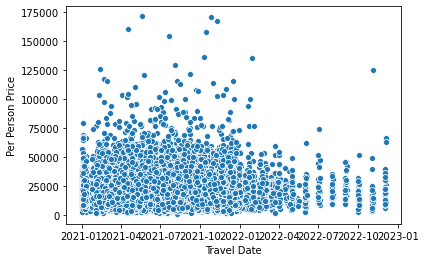

In [12]:
# average price

sns.scatterplot(x=df[~df['Per Person Price'].isna()]['Travel Date'], y=df[~df['Per Person Price'].isna()]['Per Person Price'])

In [13]:
df.sort_values("Travel Date", inplace=True)


In [14]:
df['package_type_price_100'] = df.groupby("Package Type")['Per Person Price'].transform(lambda s: s.rolling(100, min_periods=1).mean())
df['package_type_price_1000'] = df.groupby("Package Type")['Per Person Price'].transform(lambda s: s.rolling(1000, min_periods=1).mean())

In [15]:
df['start_city_price_100'] = df.groupby("Start City")['Per Person Price'].transform(lambda s: s.rolling(100, min_periods=1).mean())
df['start_city_price_1000'] = df.groupby("Start City")['Per Person Price'].transform(lambda s: s.rolling(1000, min_periods=1).mean())

In [16]:
df.drop(columns=['Travel Date'], inplace=True)


<AxesSubplot:>

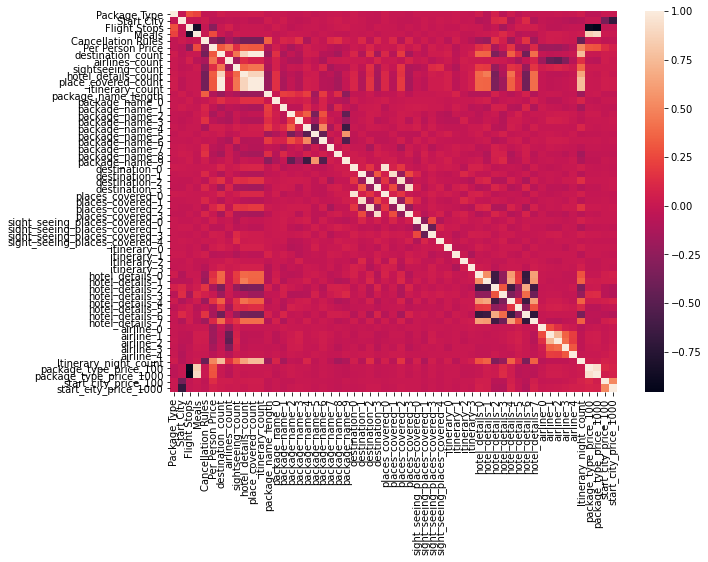

In [17]:
plt.figure(figsize=(10,7))

sns.heatmap(df.corr(method ='pearson'), 
        xticklabels=df.corr(method ='pearson').columns,
        yticklabels=df.corr(method ='pearson').columns)


<AxesSubplot:xlabel='Package Type', ylabel='Per Person Price'>

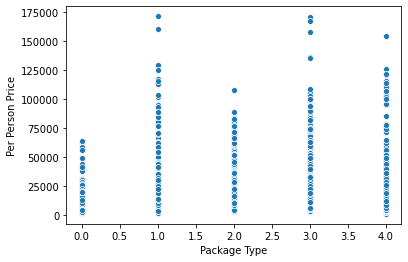

In [18]:
sns.scatterplot(y='Per Person Price', x='Package Type', data=df[~df['Per Person Price'].isna()])

<AxesSubplot:xlabel='destination_count', ylabel='Per Person Price'>

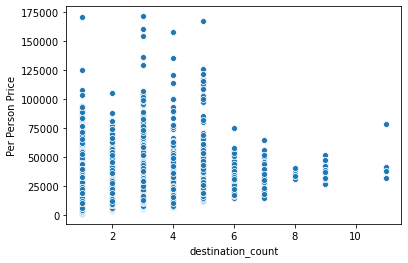

In [19]:
sns.scatterplot(y='Per Person Price', x='destination_count', data=df[~df['Per Person Price'].isna()])

<AxesSubplot:xlabel='airlines_count', ylabel='Per Person Price'>

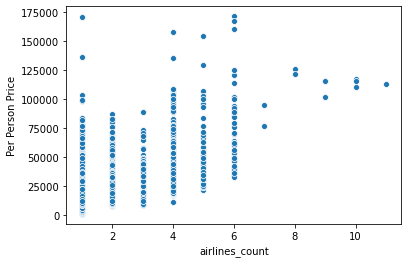

In [20]:
sns.scatterplot(y='Per Person Price', x='airlines_count', data=df[~df['Per Person Price'].isna()])

In [21]:
df.groupby(['Package Type', 'airlines_count']).ngroup()

3393     21
572      26
18048     4
11995    20
15242    20
         ..
29518    26
7783     14
13089    21
29262     4
22240    16
Length: 30000, dtype: int64

<AxesSubplot:xlabel='Start City', ylabel='Per Person Price'>

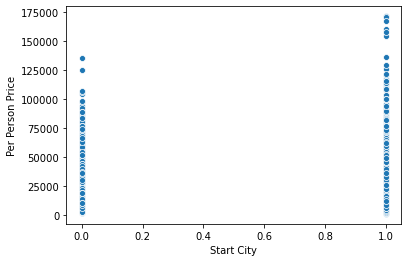

In [22]:
sns.scatterplot(y='Per Person Price', x='Start City', data=df[~df['Per Person Price'].isna()])

<AxesSubplot:xlabel='Itinerary_night_count', ylabel='Per Person Price'>

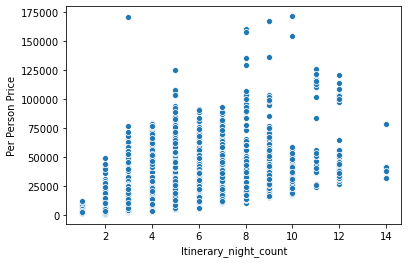

In [23]:
sns.scatterplot(y='Per Person Price', x='Itinerary_night_count', data=df[~df['Per Person Price'].isna()])

<AxesSubplot:xlabel='itinerary_count', ylabel='Per Person Price'>

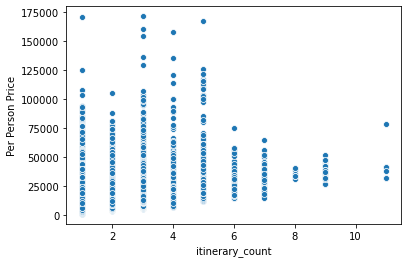

In [24]:
sns.scatterplot(y='Per Person Price', x='itinerary_count', data=df[~df['Per Person Price'].isna()])

<AxesSubplot:xlabel='Flight Stops', ylabel='Per Person Price'>

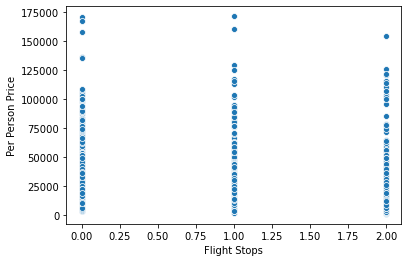

In [25]:
sns.scatterplot(y='Per Person Price', x='Flight Stops', data=df[~df['Per Person Price'].isna()])

In [26]:
df['PT_AC'] = df.groupby(['Package Type', 'airlines_count']).ngroup().astype('int')
df['PT_DC'] = df.groupby(['Package Type', 'destination_count']).ngroup().astype('int')
df['PT_SC'] = df.groupby(['Package Type', 'Start City']).ngroup().astype('int')
df['PT_NC'] = df.groupby(['Package Type', 'Itinerary_night_count']).ngroup().astype('int')
df['PT_IC'] = df.groupby(['Package Type', 'itinerary_count']).ngroup().astype('int')
df['PT_FS'] = df.groupby(['Package Type', 'Flight Stops']).ngroup().astype('int')
df['PT_CR'] = df.groupby(['Package Type', 'Cancellation Rules']).ngroup().astype('int')


df['SC_AC'] = df.groupby(['Start City', 'airlines_count']).ngroup().astype('int')
df['SC_DC'] = df.groupby(['Start City', 'destination_count']).ngroup().astype('int')
df['SC_NC'] = df.groupby(['Start City', 'Itinerary_night_count']).ngroup().astype('int')
df['SC_IC'] = df.groupby(['Start City', 'itinerary_count']).ngroup().astype('int')
df['SC_FS'] = df.groupby(['Start City', 'Flight Stops']).ngroup().astype('int')
df['SC_CR'] = df.groupby(['Start City', 'Cancellation Rules']).ngroup().astype('int')

df['CR_AC'] = df.groupby(['Cancellation Rules', 'airlines_count']).ngroup().astype('int')
df['CR_DC'] = df.groupby(['Cancellation Rules', 'destination_count']).ngroup().astype('int')
df['CR_SC'] = df.groupby(['Cancellation Rules', 'Start City']).ngroup().astype('int')
df['CR_NC'] = df.groupby(['Cancellation Rules', 'Itinerary_night_count']).ngroup().astype('int')
df['CR_IC'] = df.groupby(['Cancellation Rules', 'itinerary_count']).ngroup().astype('int')
df['CR_FS'] = df.groupby(['Cancellation Rules', 'Flight Stops']).ngroup().astype('int')


In [27]:
df['start_city_mean'] = df.groupby('Start City')['Per Person Price'].transform('mean')
df['start_city_sum'] = df.groupby('Start City')['Per Person Price'].transform('sum')

df['package_type_mean'] = df.groupby("Package Type")['Per Person Price'].transform('mean')
df['package_type_sum'] = df.groupby("Package Type")['Per Person Price'].transform('sum')


In [28]:

df.columns,len(df.columns)

(Index(['Uniq Id', 'Package Type', 'Start City', 'Flight Stops', 'Meals',
        'Cancellation Rules', 'Per Person Price', 'destination_count',
        'airlines_count', 'sightseeing_count', 'hotel_details_count',
        'place_covered_count', 'itinerary_count', 'package_name_length',
        'package_name_0', 'package_name_1', 'package_name_2', 'package_name_3',
        'package_name_4', 'package_name_5', 'package_name_6', 'package_name_7',
        'package_name_8', 'package_name_9', 'destination_0', 'destination_1',
        'destination_2', 'destination_3', 'places_covered_0',
        'places_covered_1', 'places_covered_2', 'places_covered_3',
        'sight_seeing_places_covered_0', 'sight_seeing_places_covered_1',
        'sight_seeing_places_covered_3', 'sight_seeing_places_covered_4',
        'itinerary_0', 'itinerary_1', 'itinerary_2', 'itinerary_3',
        'hotel_details_0', 'hotel_details_1', 'hotel_details_2',
        'hotel_details_3', 'hotel_details_4', 'hotel_details_5'

In [29]:
dict(zip(df.columns, df.nunique().values))

{'Uniq Id': 30000,
 'Package Type': 5,
 'Start City': 2,
 'Flight Stops': 3,
 'Meals': 4,
 'Cancellation Rules': 10,
 'Per Person Price': 17138,
 'destination_count': 10,
 'airlines_count': 11,
 'sightseeing_count': 23,
 'hotel_details_count': 10,
 'place_covered_count': 10,
 'itinerary_count': 10,
 'package_name_length': 12,
 'package_name_0': 29986,
 'package_name_1': 29987,
 'package_name_2': 29987,
 'package_name_3': 29984,
 'package_name_4': 29986,
 'package_name_5': 29986,
 'package_name_6': 29984,
 'package_name_7': 29984,
 'package_name_8': 29986,
 'package_name_9': 29988,
 'destination_0': 7703,
 'destination_1': 7701,
 'destination_2': 7701,
 'destination_3': 7702,
 'places_covered_0': 7755,
 'places_covered_1': 7755,
 'places_covered_2': 7755,
 'places_covered_3': 7754,
 'sight_seeing_places_covered_0': 12352,
 'sight_seeing_places_covered_1': 12350,
 'sight_seeing_places_covered_3': 12349,
 'sight_seeing_places_covered_4': 12352,
 'itinerary_0': 968,
 'itinerary_1': 968,
 '

In [30]:
df.to_csv("features.csv", index=False)